# Feature visualisation for shark classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import sys
sys.path.append("utilities/pytorch-cnn-visualizations/src/")
from guided_backprop import GuidedBackprop
from gradcam import GradCam
from guided_gradcam import guided_grad_cam
from generate_class_specific_samples import ClassSpecificImageGeneration
from misc_functions import (convert_to_grayscale,
                            save_gradient_images,get_positive_negative_saliency)


In [20]:
input_dir = '/Users/alex/Desktop/Projects/wwf_shark_id/results/finetune_nofeat_vgg19bn/'
data_dir = '/Users/alex/Desktop/Projects/wwf_shark_id/data/tmp/'

In [21]:
names = list(np.sort(os.listdir(data_dir+'train')))

In [33]:
### Create dataset 

input_size = 224
data_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_transform2 = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor()
       
    ])

x='train'
dataset2 = datasets.ImageFolder(os.path.join(data_dir, x), data_transform)
dataset = datasets.ImageFolder(os.path.join(data_dir, x), data_transform2)

## Get images

In [34]:
i = 0

orig_image, cls = dataset[i]
prep_image, cls2 = dataset2[i]

target_class = cls


In [35]:
print(names[target_class])

white_shark


In [36]:
# For running net on.

orig_image = orig_image.unsqueeze(0)
prep_image = prep_image.unsqueeze(0)

#guided grads
prep_image = torch.autograd.Variable(prep_image, requires_grad=True)
orig_image = torch.autograd.Variable(orig_image, requires_grad=True)

(224, 224, 3)


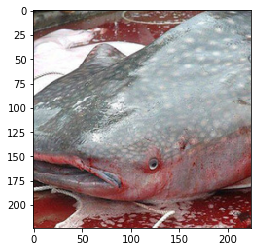

In [37]:
#For plotting
orig_image_plot = torch.squeeze(orig_image).permute(1, 2, 0).detach().numpy()
prep_image_plot = torch.squeeze(prep_image).permute(1, 2, 0).detach().numpy()
print(orig_image_plot.shape)
plt.imshow(orig_image_plot)
plt.savefig('figures/orig_image_'+str(i)+'_'+names[target_class])

## Guided backprop

In [86]:
### Load model VGG
model_ft = models.vgg19_bn(pretrained=False)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 7)

model_ft.load_state_dict(torch.load(os.path.join(input_dir, 'models', 'best_model.torch.tar')))

<All keys matched successfully>

In [61]:
GBP = GuidedBackprop(model_ft)
guided_grads = GBP.generate_gradients(orig_image, target_class)

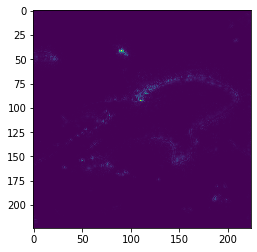

In [64]:
plt.imshow(grads)

In [33]:
### Save figures

file_name_to_export = "shark_image_%d_class_%s"%(i,names[target_class])
# Save colored gradients
save_gradient_images(guided_grads, 'figures', file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, 'figures',  file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, 'figures',  file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, 'figures',  file_name_to_export + '_neg_sal')

## Layer and filter activation with guided backprop

## Guided backprop X image

In [74]:
### Load model VGG
model_ft = models.vgg19_bn(pretrained=False)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 7)

model_ft.load_state_dict(torch.load(os.path.join(input_dir, 'models', 'best_model.torch.tar')))

<All keys matched successfully>

In [75]:
GBP = GuidedBackprop(model_ft)
guided_grads = GBP.generate_gradients(prep_image, target_class)
grad_times_image = guided_grads[0] * prep_image.detach().numpy()[0]
grayscale_gradximage = convert_to_grayscale(grad_times_image)

In [76]:
file_name_to_export = "shark_image_%d_class_%s"%(i,names[target_class])
save_gradient_images(grayscale_gradximage, 'figures',
                     file_name_to_export + '_guided_grad_times_image_gray')

## Guided grad cam

In [38]:
### Load model VGG
model_ft = models.vgg19_bn(pretrained=False)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 7)

model_ft.load_state_dict(torch.load(os.path.join(input_dir, 'models', 'best_model.torch.tar')))

<All keys matched successfully>

In [39]:
# Grad cam
gcv2 = GradCam(model_ft, target_layer=51)
# Generate cam mask
cam = gcv2.generate_cam(prep_image, target_class)

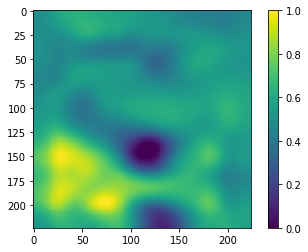

In [40]:
plt.imshow(cam)
plt.colorbar()

In [41]:
# Guided backprop
GBP = GuidedBackprop(model_ft)
# Get gradients
guided_grads = GBP.generate_gradients(prep_image, target_class)

In [42]:
# Guided Grad cam
file_name_to_export = "shark_image_%d_class_%s"%(i,names[target_class])
cam_gb = guided_grad_cam(cam, guided_grads)
save_gradient_images(cam_gb, 'figures', file_name_to_export + '_GGrad_Cam')
grayscale_cam_gb = convert_to_grayscale(cam_gb)
save_gradient_images(grayscale_cam_gb, 'figures', file_name_to_export + '_GGrad_Cam_gray')

## Class specific image generation

In [38]:
### Load model VGG
model_ft = models.vgg19_bn(pretrained=False)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 7)

model_ft.load_state_dict(torch.load(os.path.join(input_dir, 'models', 'best_model.torch.tar')))

<All keys matched successfully>

In [39]:
csig = ClassSpecificImageGeneration(model_ft, target_class, L2=True, lam = 5e-3)
csig.generate("L2_lam_5e-3_whaleshark")

Iteration: 1 Loss 1284.80
Iteration: 2 Loss 1128.32
Iteration: 3 Loss 984.98
Iteration: 4 Loss 863.25
Iteration: 5 Loss 757.68
Iteration: 6 Loss 667.88
Iteration: 7 Loss 580.74
Iteration: 8 Loss 501.75
Iteration: 9 Loss 433.96
Iteration: 10 Loss 380.25
Iteration: 11 Loss 316.16
Iteration: 12 Loss 261.80
Iteration: 13 Loss 219.11
Iteration: 14 Loss 186.41
Iteration: 15 Loss 139.08
Iteration: 16 Loss 112.05
Iteration: 17 Loss 95.73
Iteration: 18 Loss 72.53
Iteration: 19 Loss 48.94
Iteration: 20 Loss 33.63
Iteration: 21 Loss 16.85
Iteration: 22 Loss 12.69
Iteration: 23 Loss 10.29
Iteration: 24 Loss -3.86
Iteration: 25 Loss -25.47
Iteration: 26 Loss -31.31
Iteration: 27 Loss -43.75
Iteration: 28 Loss -39.65
Iteration: 29 Loss -38.54
Iteration: 30 Loss -50.12
Iteration: 31 Loss -56.05
Iteration: 32 Loss -56.30
Iteration: 33 Loss -49.20
Iteration: 34 Loss -62.48
Iteration: 35 Loss -70.62
Iteration: 36 Loss -79.79
Iteration: 37 Loss -87.63
Iteration: 38 Loss -75.75
Iteration: 39 Loss -83.84
I

KeyboardInterrupt: 